# Proyek Klasifikasi Gambar: [pemandangan indah]
- **Nama:** [Rahma Putri Prabowo]
- **Email:** [m891d5x1622@student]
- **ID Dicoding:** [M891D5X1622]

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install  tensorflowjs

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import zipfile
import shutil

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Scikit-learn untuk evaluasi
from sklearn.metrics import confusion_matrix, classification_report

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Cek versi
print("=" * 70)
print("LIBRARY VERSIONS")
print("=" * 70)
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"NumPy version: {np.__version__}")
print("=" * 70)

# Cek GPU availability
print("\nGPU Availability:")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPU available: {len(gpus)} device(s)")
    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print(" No GPU found, using CPU")
print("=" * 70)

LIBRARY VERSIONS
TensorFlow version: 2.19.0
Keras version: 3.10.0
NumPy version: 2.0.2

GPU Availability:
✓ GPU available: 1 device(s)
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# Install Kaggle
!pip install -q kaggle

# Upload kaggle.json
from google.colab import files
print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify setup
!kaggle --version

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API 1.7.4.5


## Data Preparation

### Data Loading

In [4]:
# Download dataset
!kaggle datasets download -d puneet6060/intel-image-classification

# Extract
!unzip -q intel-image-classification.zip -d dataset
print("Dataset extracted to: dataset/")

# Poin perbaikan: Menggabungkan data ke satu folder sumber 'seg_data'
print("\nMENGGABUNGKAN DATA")
print("=" * 60)
SOURCE_DIR = 'seg_data'
os.makedirs(SOURCE_DIR, exist_ok=True)
train_path = 'dataset/seg_train/seg_train'
test_path = 'dataset/seg_test/seg_test'

def move_files(source, destination):
    for class_folder in os.listdir(source):
        src_dir = os.path.join(source, class_folder)
        dst_dir = os.path.join(destination, class_folder)
        os.makedirs(dst_dir, exist_ok=True)
        for file_name in os.listdir(src_dir):
            try:
                shutil.move(os.path.join(src_dir, file_name), dst_dir)
            except shutil.Error:
                pass  # Added pass statement to handle the exception
    print(f"Memindahkan files dari '{source}' ke 'seg_data'...") # Corrected indentation

move_files(train_path, SOURCE_DIR)
move_files(test_path, SOURCE_DIR)

# Hitung total file setelah digabung
total_files = sum(len(files) for _, _, files in os.walk(SOURCE_DIR))
print(f"Total files in seg_data: {total_files}")

# Bersihkan direktori lama
print("\nMENGHAPUS FOLDER LAMA")
print("=" * 60)
if os.path.exists('dataset'):
    shutil.rmtree('dataset')

BASE_DIR = 'seg_data'
OUTPUT_DIR = 'split_data' # Direktori baru untuk Train, Val, Test

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 96% 334M/346M [00:00<00:00, 588MB/s]
100% 346M/346M [00:00<00:00, 609MB/s]
Dataset extracted to: dataset/

MENGGABUNGKAN DATA
Memindahkan files dari 'dataset/seg_train/seg_train' ke 'seg_data'...
Memindahkan files dari 'dataset/seg_test/seg_test' ke 'seg_data'...
Total files in seg_data: 17034

MENGHAPUS FOLDER LAMA


In [5]:
# Install split-folders
!pip install split-folders
import splitfolders

# Hyperparameters - Pindahkan definisi
IMG_SIZE = 150 # Contoh ukuran gambar
BATCH_SIZE = 32 # Contoh ukuran batch
EPOCHS = 50 # Contoh jumlah epoch

# Poin perbaikan: Pembagian dataset mandiri (Train, Val, Test)
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

print("Membagi dataset (Train: 80%, Validation: 10%, Test: 10%)...")
# Menggunakan ratio (0.8, 0.1, 0.1) untuk Train, Val, Test
splitfolders.ratio(BASE_DIR, output=OUTPUT_DIR, seed=42, ratio=(0.8, 0.1, 0.1), group_prefix=None)

TRAIN_DIR = os.path.join(OUTPUT_DIR, 'train')
VAL_DIR = os.path.join(OUTPUT_DIR, 'val')
TEST_DIR = os.path.join(OUTPUT_DIR, 'test')

# Data Augmentation hanya untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation dan test set hanya rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training Generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Validation Generator
validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Test Generator
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Print dataset info
print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Class names: {list(train_generator.class_indices.keys())}")

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

Membagi dataset (Train: 80%, Validation: 10%, Test: 10%)...


Copying files: 17034 files [00:02, 8310.96 files/s]


Found 13625 images belonging to 6 classes.
Found 1700 images belonging to 6 classes.
Found 1709 images belonging to 6 classes.

Training samples: 13625
Validation samples: 1700
Test samples: 1709
Number of classes: 6
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Data Preprocessing

#### Split Dataset

In [7]:
# Fungsi untuk menghitung jumlah gambar dan resolusi
def print_images_info(directory):
    """Print jumlah gambar per kelas dan resolusi unik"""
    unique_sizes = set()
    total_images = 0

    print("Dataset Information:")
    print("=" * 50)

    for subdir in sorted(os.listdir(directory)):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_files = [f for f in os.listdir(subdir_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            num_images = len(image_files)
            print(f"{subdir}: {num_images} images")
            total_images += num_images

            # Cek beberapa gambar untuk mendapatkan ukuran
            for img_file in image_files[:6]:  # Cek 10 gambar pertama
                img_path = os.path.join(subdir_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        unique_sizes.add(img.size)
                except:
                    pass

    print("=" * 50)
    print(f"Total images: {total_images}")
    print(f"\nUnique resolutions found:")
    for size in sorted(unique_sizes):
        print(f"  - {size[0]}x{size[1]}")

    return total_images
# Explore dataset
total_train = print_images_info(BASE_DIR)

Dataset Information:
buildings: 2628 images
forest: 2745 images
glacier: 2957 images
mountain: 3037 images
sea: 2784 images
street: 2883 images
Total images: 17034

Unique resolutions found:
  - 150x150


## Modelling

**DATA PREPARATION WITH AUGMENTATION**

In [8]:
# Hyperparameters
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 50

# Data Augmentation hanya untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% untuk validation
)

# Validation dan test set hanya rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Training set (80% dari train directory)
train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation set (20% dari train directory)
validation_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test set (dari test directory terpisah)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Define NUM_CLASSES here, after train_generator is created
NUM_CLASSES = train_generator.num_classes

# Print dataset info
print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Class names: {list(train_generator.class_indices.keys())}")

Found 13630 images belonging to 6 classes.
Found 3404 images belonging to 6 classes.
Found 1709 images belonging to 6 classes.

Training samples: 13630
Validation samples: 3404
Test samples: 1709
Number of classes: 6
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


 Visualization saved to: visualizations/sample_images_dataset.png


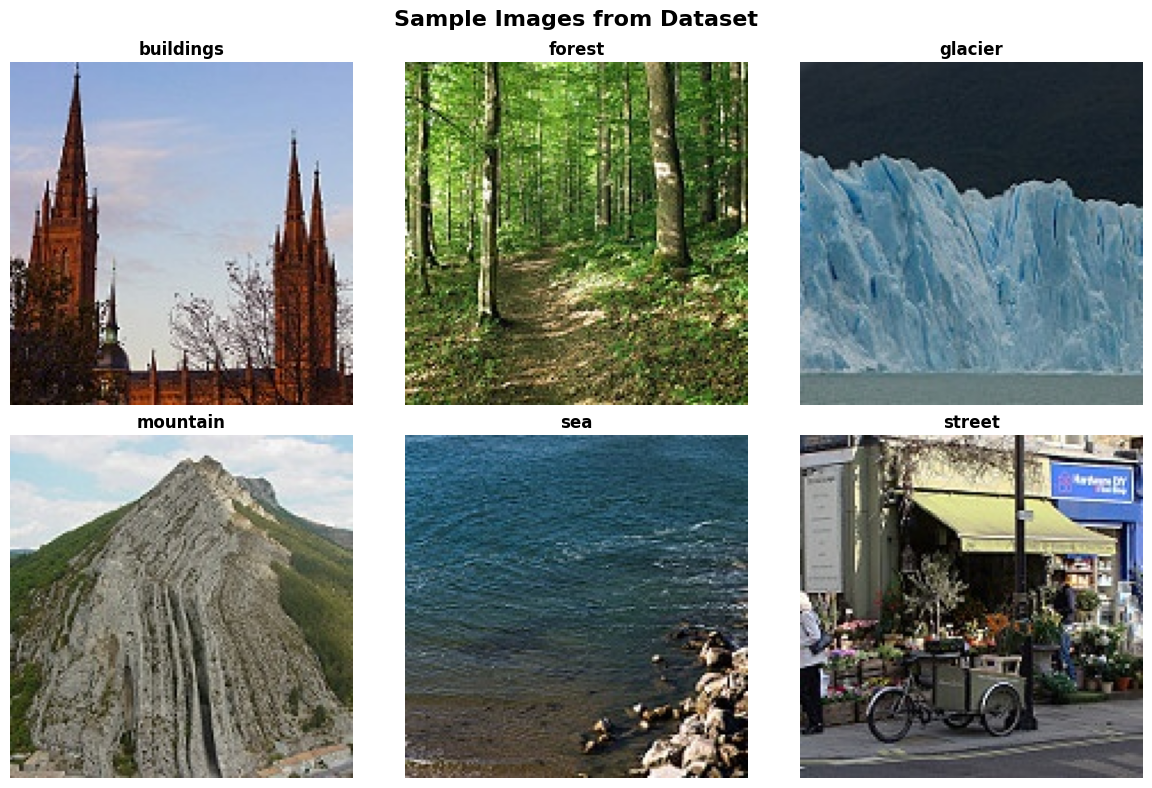

In [9]:
def visualize_samples(directory, num_samples=15, save_image=True):
    """Visualize sample images from each class"""
    classes = sorted([d for d in os.listdir(directory)
                     if os.path.isdir(os.path.join(directory, d))])

    # Hitung jumlah baris dan kolom yang dibutuhkan
    num_classes = min(len(classes), num_samples)
    cols = 3
    rows = (num_classes + cols - 1) // cols  # Ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
    fig.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')

    # Flatten axes untuk memudahkan indexing
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.ravel()

    for idx, class_name in enumerate(classes[:num_samples]):
        class_path = os.path.join(directory, class_name)
        images = [f for f in os.listdir(class_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if images:
            img_path = os.path.join(class_path, images[0])
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(class_name, fontsize=12, fontweight='bold')
            axes[idx].axis('off')

    # subplot yang tidak digunakan
    for idx in range(num_classes, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()

    # Simpan gambar
    if save_image:
        # Buat direktori visualizations jika belum ada
        os.makedirs('visualizations', exist_ok=True)

        output_path = 'visualizations/sample_images_dataset.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f" Visualization saved to: {output_path}")

    plt.show()

# Jalankan fungsi
visualize_samples(BASE_DIR, num_samples=15, save_image=True)

**BUILD CNN MODEL (Sequential)**

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Model Sequential, Conv2D, Pooling
model = Sequential([
    # Blok Konvolusi 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(), # Membantu training lebih stabil
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25), # Mencegah overfitting

    # Blok Konvolusi 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Blok Konvolusi 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Bagian Klasifikasi
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax') # Changed from 10 to NUM_CLASSES
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,527,206 (82.12 MB)

 Trainable params: 21,525,734 (82.11 MB)

 Non-trainable params: 1,472 (5.75 KB)

**CallBack**

In [16]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    TerminateOnNaN
)


### **TRAINING**

In [17]:
# Custom callback untuk stop di 95%
class StopAt95Accuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.95:
            print(f"\n Reached 95% accuracy! Stopping training.")
            self.model.stop_training = True

callbacks = [
    # Stop jika val_accuracy >= 95%
    StopAt95Accuracy(),

    # Stop jika tidak ada improvement dalam 15 epoch
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        mode='max',
        verbose=1,
        restore_best_weights=True
    ),

    # Stop jika val_loss naik terus (overfitting)
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1,
        restore_best_weights=True
    ),

    # Reduce learning rate jika stuck
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Stop jika NaN
    TerminateOnNaN()
]

### **PLOT AKURASI DAN LOSS**

In [20]:
print("\nTraining model...")
print("=" * 60)
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {train_generator.samples // BATCH_SIZE}")
print(f"Image size: {IMG_SIZE}")
print("=" * 60)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n Training completed!")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Total epochs trained: {len(history.history['accuracy'])}")


Training model...
Training samples: 13630
Validation samples: 3404
Number of classes: 6
Batch size: 32
Steps per epoch: 425
Image size: 150
Epoch 1/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5077 - loss: 1.3371

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.24236, saving model to best_model.keras
426/426 ━━━━━━━━━━━━━━━━━━━━ 144s 297ms/step - accuracy: 0.5079 - loss: 1.3366 - val_accuracy: 0.2424 - val_loss: 2.1551 - learning_rate: 0.0010
Epoch 2/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6840 - loss: 0.8559
Epoch 2: val_accuracy improved from 0.24236 to 0.71886, saving model to best_model.keras
426/426 ━━━━━━━━━━━━━━━━━━━━ 108s 253ms/step - accuracy: 0.6840 - loss: 0.8558 - val_accuracy: 0.7189 - val_loss: 0.7350 - learning_rate: 0.0010
Epoch 3/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.7138 - loss: 0.7675
Epoch 3: val_accuracy did not improve from 0.71886
426/426 ━━━━━━━━━━━━━━━━━━━━ 107s 250ms/step - accuracy: 0.7138 - loss: 0.7675 - val_accuracy: 0.4545 - val_loss: 1.9705 - learning_rate: 0.0010
Epoch 4/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7487 - loss: 0.6866
Epoch 4: val_accuracy improved from 0.71886 to 0.74647, saving model to be

In [22]:
# PENILAIAN MODEL DENGAN DATA UJI

print("\n>>> Melakukan evaluasi performa pada dataset pengujian ...")

# Menjalankan evaluasi model
# Hasil berupa [nilai_rugi, tingkat_akurasi]
eval_score = model.evaluate(test_generator, verbose=1)

uji_loss = eval_score[0]
uji_acc = eval_score[1]

print("\n==============================================")
print(f"Akurasi pada Data Uji : {uji_acc * 100:.2f}%")
print(f"Loss pada Data Uji    : {uji_loss}")
print("==============================================")

# Cek apakah akurasi sudah memenuhi kriteria minimal 85%
if uji_acc >= 0.85:
    print("\u2713 KEREN! Model kamu sudah memenuhi standar akurasi minimal 85%.")
else:
    print("\u26a0  Catatan: Akurasi pengujian masih kurang dari 85%.")


>>> Melakukan evaluasi performa pada dataset pengujian ...
 3/54 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7986 - loss: 0.5475

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8807 - loss: 0.3340

Akurasi pada Data Uji : 90.23%
Loss pada Data Uji    : 0.28316766023635864
✓ KEREN! Model kamu sudah memenuhi standar akurasi minimal 85%.


## Evaluasi dan Visualisasi

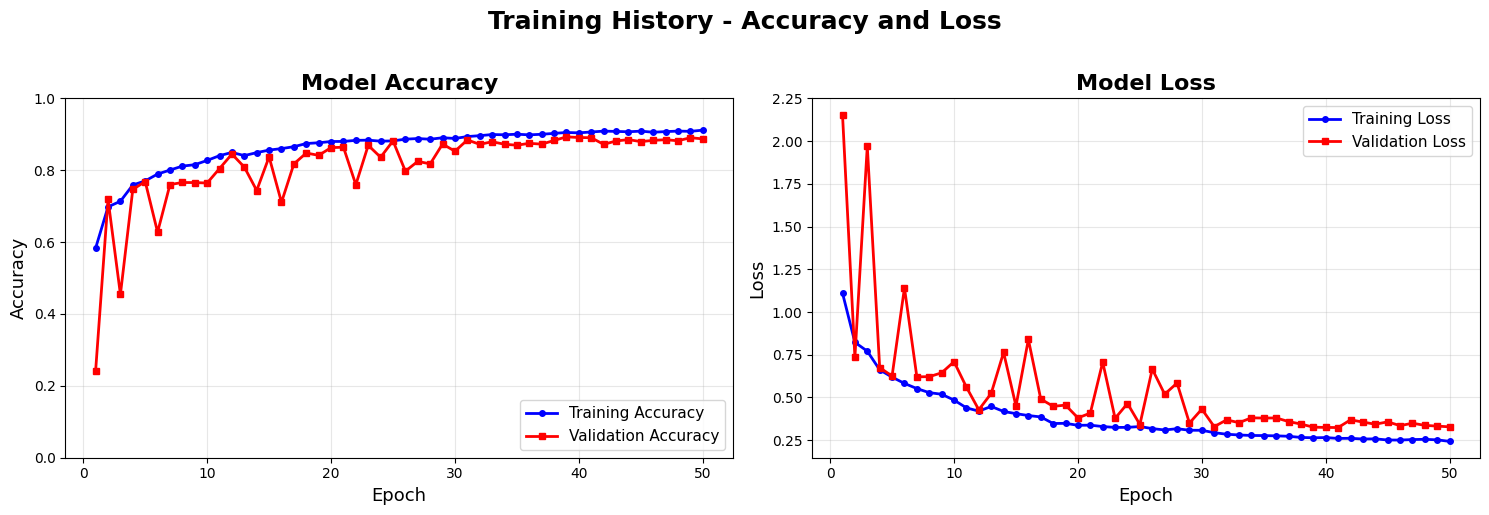


 Plot saved as 'training_history.png'


In [32]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plot accuracy and loss curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs_range = range(1, len(history.history['accuracy']) + 1)

    # Plot Accuracy
    ax1.plot(epochs_range, history.history['accuracy'],
             'b-o', label='Training Accuracy', linewidth=2, markersize=4)
    ax1.plot(epochs_range, history.history['val_accuracy'],
             'r-s', label='Validation Accuracy', linewidth=2, markersize=4)
    ax1.set_title('Model Accuracy', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=13)
    ax1.set_ylabel('Accuracy', fontsize=13)
    ax1.legend(loc='lower right', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # Plot Loss
    ax2.plot(epochs_range, history.history['loss'],
             'b-o', label='Training Loss', linewidth=2, markersize=4)
    ax2.plot(epochs_range, history.history['val_loss'],
             'r-s', label='Validation Loss', linewidth=2, markersize=4)
    ax2.set_title('Model Loss', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=13)
    ax2.set_ylabel('Loss', fontsize=13)
    ax2.legend(loc='upper right', fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.suptitle('Training History - Accuracy and Loss',
                 fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n Plot saved as 'training_history.png'")

plot_training_history(history)


## Konversi Model

### **SIMPAN MODEL (SavedModel, TFLite, TFJS)**

In [24]:
import tensorflow as tf
import tensorflowjs as tfjs
import os
import json

print("\n" + "=" * 60)
print("Saving models in multiple formats...")
print("=" * 60)

# Buat direktori untuk setiap format
os.makedirs('saved_model', exist_ok=True)
os.makedirs('tflite', exist_ok=True)
os.makedirs('tfjs_model', exist_ok=True)


Saving models in multiple formats...


In [27]:
# 1. SavedModel Format (TensorFlow)
print("\n1‣ Saving as SavedModel format...")
model.export('saved_model/my_model')
print("    Saved to: saved_model/my_model/")
print(f"      - saved_model.pb")
print(f"      - variables/")

# 2. TF-Lite Format (Mobile & Embedded)
print("\n2‣ Converting to TensorFlow Lite format...")
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Simpan model.tflite
tflite_path = 'tflite/model.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"    Saved to: {tflite_path}")
print(f"    Size: {len(tflite_model) / (1024*1024):.2f} MB")

# 3. TensorFlow.js Format (Web/Browser)
print("\n3‣ Converting to TensorFlow.js format...")
tfjs.converters.save_keras_model(model, 'tfjs_model')
print("    Saved to: tfjs_model/")

print("\n" + "=" * 60)
print("  All models saved successfully!")
print("=" * 60)
print("\n Model files:")
print("   • SavedModel: saved_model/my_model/")
print("   • TF-Lite:    tflite/model.tflite")
print("   • TFJS:       tfjs_model/")


1‣ Saving as SavedModel format...
Saved artifact at 'saved_model/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_63')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135085971923472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135085971925584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135085971925968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135085971926928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135085971926736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135085971926160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135085971926544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135085971925776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135085971927696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135085971927120: TensorSpec(shape=(), dtyp

    Saved to: tflite/model.tflite
    Size: 20.55 MB

3‣ Converting to TensorFlow.js format...
failed to lookup keras version from the file,
    this is likely a weight only file
    Saved to: tfjs_model/

  All models saved successfully!

 Model files:
   • SavedModel: saved_model/my_model/
   • TF-Lite:    tflite/model.tflite
   • TFJS:       tfjs_model/


In [28]:
# Simpan labels.txt
labels = list(train_generator.class_indices.keys())
labels_path = 'tflite/labels.txt'
with open(labels_path, 'w') as f:
    for label in labels:
        f.write(f"{label}\n")
print(f"    Saved labels to: {labels_path}")
print(f"    Total classes: {len(labels)}")

# 3. TensorFlow.js Format (Web/Browser)
print("\n3️ Converting to TensorFlow.js format...")
tfjs.converters.save_keras_model(model, 'tfjs_model')
print("    Saved to: tfjs_model/")
print(f"      - model.json")
print(f"      - group1-shard1of1.bin")

print("\n" + "=" * 60)
print(" All models saved successfully!")
print("=" * 60)
print("\n Directory Structure:")
print("├── saved_model/")
print("│   ├── saved_model.pb")
print("│   ├── Assets.pb")
print("│   ├── variables/")
print("│   │   ├── variables.data-00000-of-00001")
print("│   │   └── variables.index")
print("│   └── fingerprint.pb")
print("├── tflite/")
print("│   ├── model.tflite")
print("│   └── labels.txt")
print("└── tfjs_model/")
print("    ├── model.json")
print("    └── group1-shard1of1.bin")
print("=" * 60)

    Saved labels to: tflite/labels.txt
    Total classes: 6

3️ Converting to TensorFlow.js format...
failed to lookup keras version from the file,
    this is likely a weight only file
    Saved to: tfjs_model/
      - model.json
      - group1-shard1of1.bin

 All models saved successfully!

 Directory Structure:
├── saved_model/
│   ├── saved_model.pb
│   ├── Assets.pb
│   ├── variables/
│   │   ├── variables.data-00000-of-00001
│   │   └── variables.index
│   └── fingerprint.pb
├── tflite/
│   ├── model.tflite
│   └── labels.txt
└── tfjs_model/
    ├── model.json
    └── group1-shard1of1.bin


## Inference (Optional)


MEMUAT SAMPEL GAMBAR UNTUK INFERENSI
Total gambar yang diambil untuk inference: 18

Memuat model SavedModel...


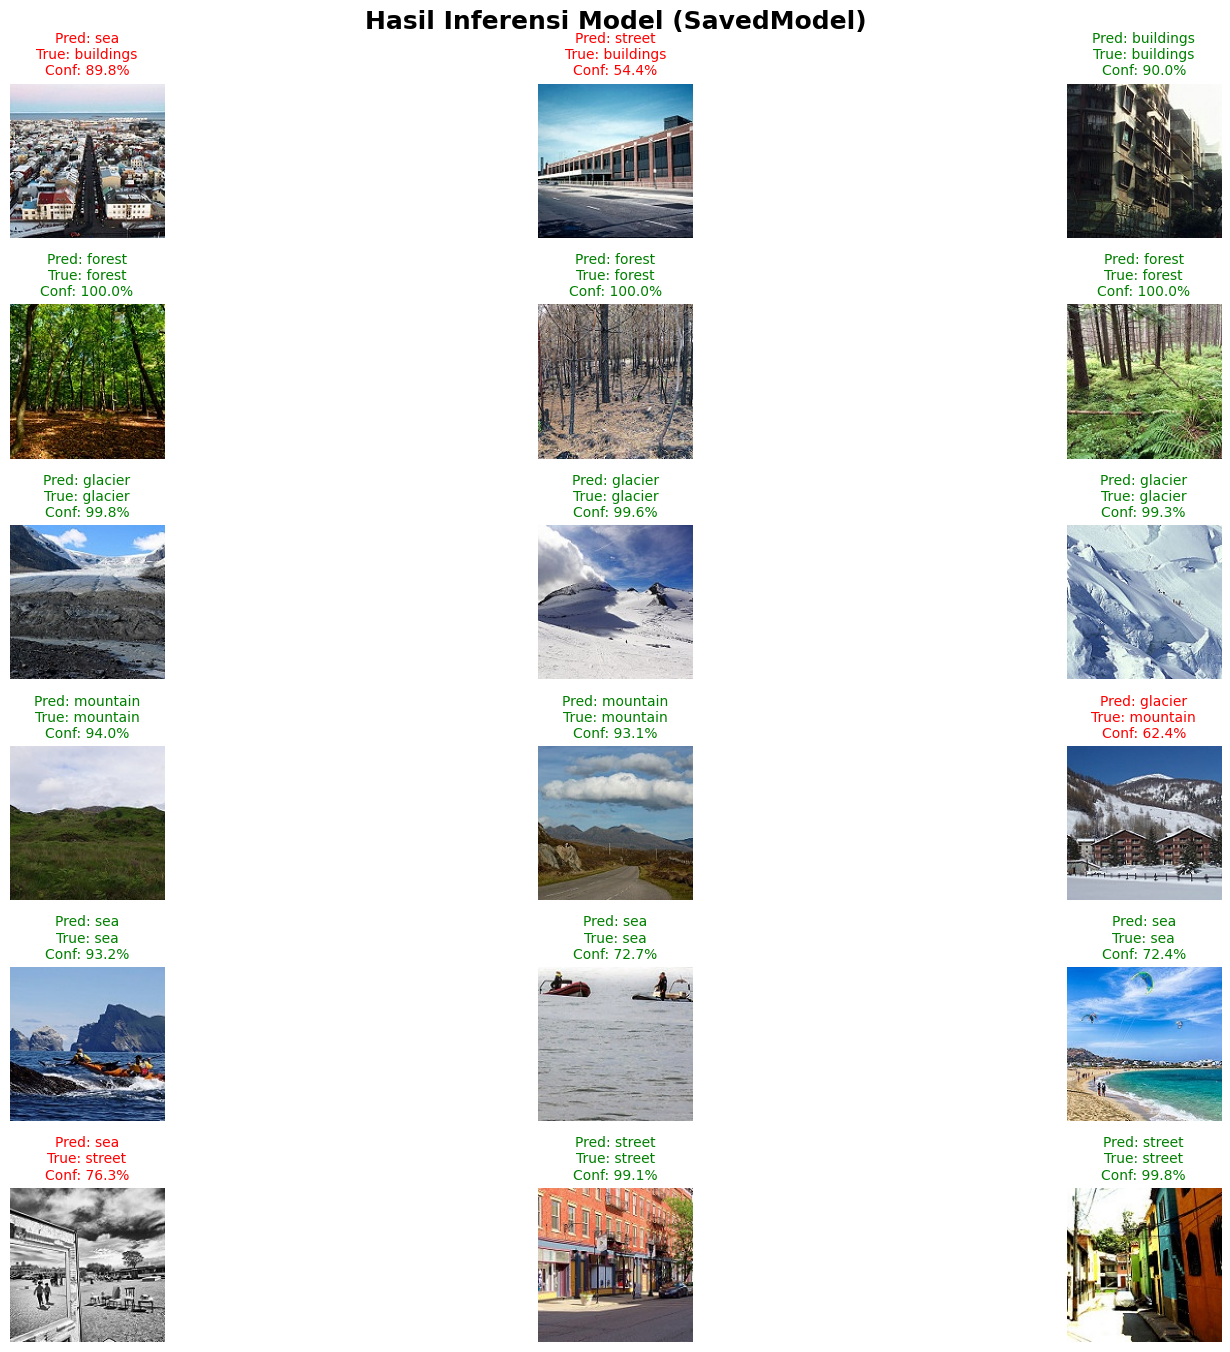


RINGKASAN PREDIKSI
Gambar 1:
 - Label Asli    : buildings
 - Prediksi      : sea
 - Confidence    : 89.80%
--------------------------------------------------
Gambar 2:
 - Label Asli    : buildings
 - Prediksi      : street
 - Confidence    : 54.43%
--------------------------------------------------
Gambar 3:
 - Label Asli    : buildings
 - Prediksi      : buildings
 - Confidence    : 90.04%
--------------------------------------------------
Gambar 4:
 - Label Asli    : forest
 - Prediksi      : forest
 - Confidence    : 100.00%
--------------------------------------------------
Gambar 5:
 - Label Asli    : forest
 - Prediksi      : forest
 - Confidence    : 100.00%
--------------------------------------------------
Gambar 6:
 - Label Asli    : forest
 - Prediksi      : forest
 - Confidence    : 100.00%
--------------------------------------------------
Gambar 7:
 - Label Asli    : glacier
 - Prediksi      : glacier
 - Confidence    : 99.77%
--------------------------------------------

In [30]:
# ======================================================
# INFERENCE (Optional) - Visualisasi Prediksi Model
# ======================================================

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import os

print("\n" + "="*70)
print("MEMUAT SAMPEL GAMBAR UNTUK INFERENSI")
print("="*70)

# Ambil nama kelas dari hasil training
CLASS_NAMES = labels
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)

# Ambil beberapa sampel dari test directory
sample_paths = []
samples_per_class = 3   # ambil 3 gambar per kelas

for cls in CLASS_NAMES:
    cls_path = os.path.join(TEST_DIR, cls)
    files = os.listdir(cls_path)[:samples_per_class]   # ambil 3 gambar pertama
    file_paths = [os.path.join(cls_path, f) for f in files]
    sample_paths.extend(file_paths)

print(f"Total gambar yang diambil untuk inference: {len(sample_paths)}")

# =========================================
# Mengolah gambar menjadi array model-ready
# =========================================
processed_images = []
true_labels = []

for img_path in sample_paths:
    img = load_img(img_path, target_size=TARGET_SIZE)
    img_arr = img_to_array(img) / 255.0
    processed_images.append(img_arr)

    # label asli
    folder_name = os.path.basename(os.path.dirname(img_path))
    true_labels.append(CLASS_NAMES.index(folder_name))

processed_images = np.array(processed_images)
true_labels = np.array(true_labels)

# ===========================
# Memuat model SavedModel
# ===========================
print("\nMemuat model SavedModel...")
saved_layer = tf.keras.layers.TFSMLayer(
    'saved_model/my_model',
    call_endpoint="serve"
)

# Prediksi
pred_raw = saved_layer(processed_images)
if isinstance(pred_raw, dict):
    output_key = list(pred_raw.keys())[0]
    pred_raw = pred_raw[output_key]

pred_classes = np.argmax(pred_raw, axis=1)
pred_conf = np.max(pred_raw, axis=1) * 100


# ===========================
# Tampilkan grid gambar
# ===========================
num_images = len(processed_images)
cols = 3
rows = (num_images // cols) + 1

plt.figure(figsize=(16, 16))
plt.suptitle("Hasil Inferensi Model (SavedModel)", fontsize=18, fontweight="bold")

for i in range(num_images):
    plt.subplot(rows, cols, i+1)
    plt.imshow(processed_images[i])

    pred_label = CLASS_NAMES[pred_classes[i]]
    true_label = CLASS_NAMES[true_labels[i]]
    confidence = pred_conf[i]

    color = "green" if pred_label == true_label else "red"

    plt.title(
        f"Pred: {pred_label}\nTrue: {true_label}\nConf: {confidence:.1f}%",
        color=color,
        fontsize=10
    )
    plt.axis("off")

plt.tight_layout()
plt.show()


# ======================================================
# RINGKASAN HASIL INFERENSI
# ======================================================
print("\n" + "="*70)
print("RINGKASAN PREDIKSI")
print("="*70)

for i in range(num_images):
    print(f"Gambar {i+1}:")
    print(f" - Label Asli    : {CLASS_NAMES[true_labels[i]]}")
    print(f" - Prediksi      : {CLASS_NAMES[pred_classes[i]]}")
    print(f" - Confidence    : {pred_conf[i]:.2f}%")
    print("--------------------------------------------------")

In [33]:
!pip freeze > requirements.txt

In [34]:
!cat requirements.txt

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.11.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.1
altair==5.5.0
annotated-doc==0.0.4
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.19
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.2
arrow==1.4.0
arviz==0.22.0
astropy==7.1.1
astropy-iers-data==0.2025.11.10.0.38.31
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.1.0
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.5
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.28.0
bigquery-magics==0.10.3
bleach==6.3.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.11.0
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
brotli==1.2.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.10.5
cffi==2.0.0
chardet==5.2.0
charset-normalizer==

In [35]:
from google.colab import files
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>